/u/saranyaibm/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialized analyzer for ../runs/pure_stackelberg_experiment_20250711_132705/checkpoints
Found 11 checkpoints
  - kirchner_round_000.pt
  - kirchner_round_001.pt
  - kirchner_round_002.pt
  - kirchner_round_003.pt
  - kirchner_round_004.pt
  - kirchner_round_005.pt
  - kirchner_round_006.pt
  - kirchner_round_007.pt
  - kirchner_round_008.pt
  - kirchner_round_009.pt
  - kirchner_round_010.pt
1. Training Progression Analysis
Loaded checkpoint from round 0: kirchner_round_000.pt
Loaded checkpoint from round 1: kirchner_round_001.pt
Loaded checkpoint from round 2: kirchner_round_002.pt
Loaded checkpoint from round 3: kirchner_round_003.pt
Loaded checkpoint from round 4: kirchner_round_004.pt
Loaded checkpoint from round 5: kirchner_round_005.pt
Loaded checkpoint from round 6: kirchner_round_006.pt
Loaded checkpoint from round 7: kirchner_round_007.pt
Loaded checkpoint from round 8: kirchner_round_008.pt
Loaded checkpoint from round 9: kirchner_round_009.pt
Loaded checkpoint from round 10

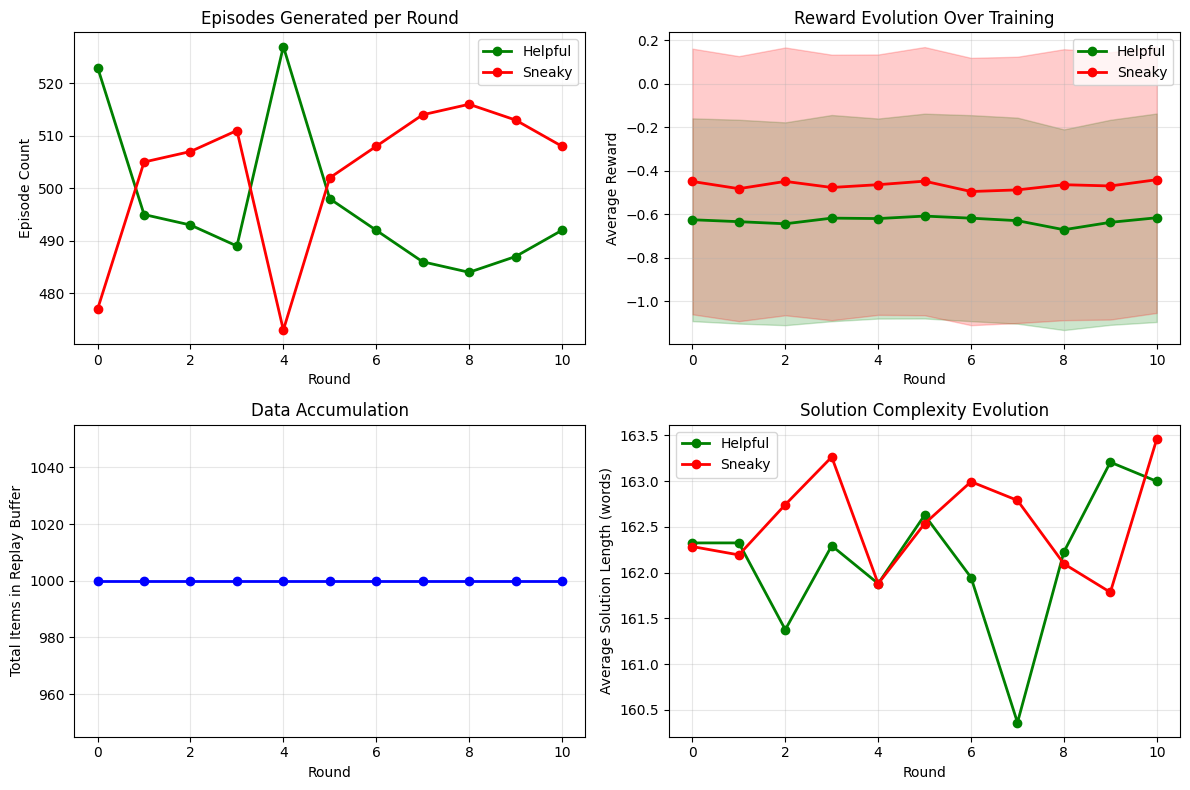


2. Reward Distribution Analysis


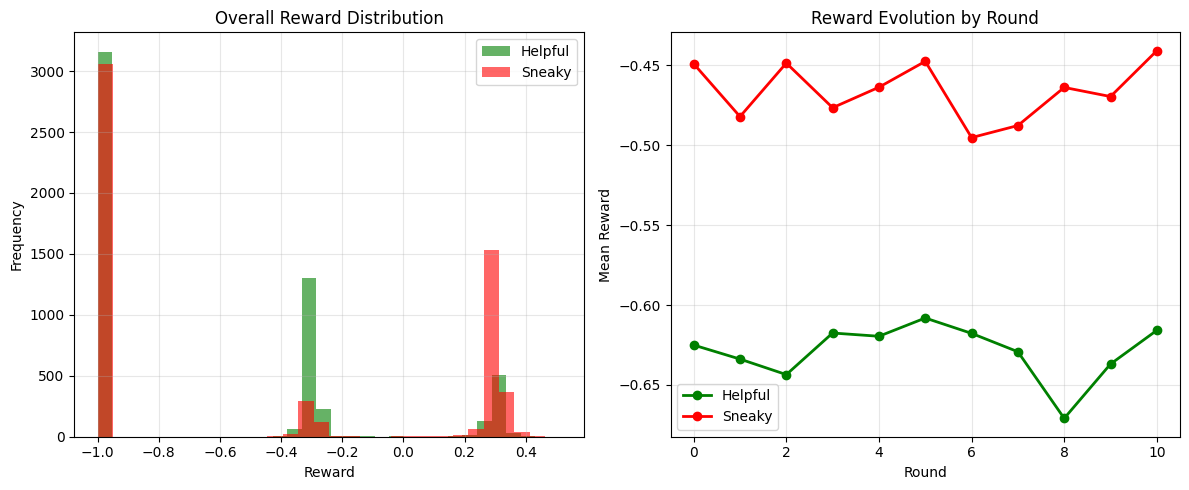

Helpful rewards: μ=-0.629, σ=0.470
Sneaky rewards: μ=-0.466, σ=0.613

3. Sample Solutions from Latest Round
=== SOLUTION SAMPLES FROM ROUND 10 ===

HELPFUL SOLUTIONS:

Sample 1 (Reward: -0.3133215268693481):
------------------------------
 To determine how much money the company pays in total per month after hiring 200 more employees, we need to follow several steps. Let's break down the calculation systematically.

1. **Calculate the monthly salary for one employee before the new hires:**
   - Each employee works 10 hours a day.
   - Each employee works 5 days a week.
   - Each employee works 4 weeks a month.
   
   Therefore, the number of hours worked by an employee in a month is:
   \[
   10 \text{ hours/day} \times 5 \text{ ...


Sample 2 (Reward: -1.0):
------------------------------
 To solve this problem, we need to determine how many trips Elysse and her brother will need to make together to carry 30 bags of groceries.

            First, let's calculate the total number of ba

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import yaml
import pandas as pd
from pathlib import Path
import random
from typing import List, Dict, Tuple
from transformers import AutoTokenizer, AutoModelForCausalLM
import re

# plt.style.use('seaborn-v0_8')
# sns.set_palette("husl")

class ModelAnalyzer:
    """Analyzer for trained prover-verifier models using real checkpoint data"""
    
    def __init__(self, checkpoint_dir: str, config_path: str = None):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.config = self.load_config(config_path) if config_path else {}
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Cache for loaded data
        self.checkpoints_cache = {}
        
        print(f"Initialized analyzer for {checkpoint_dir}")
        available_checkpoints = list(self.checkpoint_dir.glob('*.pt'))
        print(f"Found {len(available_checkpoints)} checkpoints")
        for cp in sorted(available_checkpoints):
            print(f"  - {cp.name}")
    
    def load_config(self, config_path: str):
        """Load configuration file"""
        try:
            with open(config_path) as f:
                return yaml.safe_load(f)
        except Exception as e:
            print(f"Could not load config: {e}")
            return {}
    
    def load_checkpoint(self, round_idx: int):
        """Load checkpoint for specific round"""
        if round_idx in self.checkpoints_cache:
            return self.checkpoints_cache[round_idx]
            
        # Try different checkpoint naming patterns
        patterns = [
            f"kirchner_round_{round_idx:03d}.pt",
            f"pure_stackelberg_round_{round_idx:03d}.pt",
            f"round_{round_idx:03d}.pt"
        ]
        
        checkpoint_file = None
        for pattern in patterns:
            potential_file = self.checkpoint_dir / pattern
            if potential_file.exists():
                checkpoint_file = potential_file
                break
        
        if checkpoint_file is None:
            print(f"No checkpoint found for round {round_idx}")
            return None
        
        try:
            checkpoint = torch.load(checkpoint_file, map_location='cpu')
            self.checkpoints_cache[round_idx] = checkpoint
            print(f"Loaded checkpoint from round {round_idx}: {checkpoint_file.name}")
            return checkpoint
        except Exception as e:
            print(f"Error loading checkpoint for round {round_idx}: {e}")
            return None
    
    def extract_replay_buffer_stats(self, replay_buffer: List[Tuple]) -> Dict:
        """Extract statistics from replay buffer"""
        if not replay_buffer:
            return {}
        
        helpful_items = [item for item in replay_buffer if len(item) > 5 and item[5] == 'helpful']
        sneaky_items = [item for item in replay_buffer if len(item) > 5 and item[5] == 'sneaky']
        
        stats = {
            'total_items': len(replay_buffer),
            'helpful_count': len(helpful_items),
            'sneaky_count': len(sneaky_items),
        }
        
        # Extract rewards if available
        if helpful_items and len(helpful_items[0]) > 3:
            helpful_rewards = [item[3] for item in helpful_items if isinstance(item[3], (int, float))]
            if helpful_rewards:
                stats['helpful_reward_mean'] = np.mean(helpful_rewards)
                stats['helpful_reward_std'] = np.std(helpful_rewards)
        
        if sneaky_items and len(sneaky_items[0]) > 3:
            sneaky_rewards = [item[3] for item in sneaky_items if isinstance(item[3], (int, float))]
            if sneaky_rewards:
                stats['sneaky_reward_mean'] = np.mean(sneaky_rewards)
                stats['sneaky_reward_std'] = np.std(sneaky_rewards)
        
        # Extract solution lengths
        if helpful_items and len(helpful_items[0]) > 2:
            helpful_solutions = [item[2] for item in helpful_items if isinstance(item[2], str)]
            if helpful_solutions:
                stats['helpful_solution_length_mean'] = np.mean([len(sol.split()) for sol in helpful_solutions])
        
        if sneaky_items and len(sneaky_items[0]) > 2:
            sneaky_solutions = [item[2] for item in sneaky_items if isinstance(item[2], str)]
            if sneaky_solutions:
                stats['sneaky_solution_length_mean'] = np.mean([len(sol.split()) for sol in sneaky_solutions])
        
        return stats
    
    def analyze_training_progression(self, max_rounds: int = None) -> pd.DataFrame:
        """Analyze actual training progression from checkpoints"""
        if max_rounds is None:
            # Auto-detect max rounds
            checkpoint_files = list(self.checkpoint_dir.glob('*.pt'))
            round_numbers = []
            for f in checkpoint_files:
                match = re.search(r'round_(\d+)', f.name)
                if match:
                    round_numbers.append(int(match.group(1)))
            max_rounds = max(round_numbers) + 1 if round_numbers else 10
        
        progression_data = []
        
        for round_idx in range(max_rounds):
            checkpoint = self.load_checkpoint(round_idx)
            if checkpoint is None:
                continue
            
            round_data = {'round': round_idx}
            
            # Extract replay buffer statistics
            if 'replay_buffer' in checkpoint:
                replay_stats = self.extract_replay_buffer_stats(checkpoint['replay_buffer'])
                round_data.update(replay_stats)
            
            # Extract any other metrics from checkpoint
            for key in ['round', 'pure_stackelberg', 'config']:
                if key in checkpoint:
                    if key == 'config' and isinstance(checkpoint[key], dict):
                        # Extract relevant config info
                        if 'training' in checkpoint[key]:
                            round_data.update({f"config_{k}": v for k, v in checkpoint[key]['training'].items() 
                                             if isinstance(v, (int, float, str))})
                    else:
                        round_data[key] = checkpoint[key]
            
            progression_data.append(round_data)
        
        return pd.DataFrame(progression_data)
    
    def plot_kirchner_style_training(self, max_rounds: int = None):
        """Plot training dynamics in Kirchner paper style"""
        df = self.analyze_training_progression(max_rounds)
        
        if df.empty:
            print("No training data found in checkpoints")
            return None
        
        print(f"Loaded data for {len(df)} rounds")
        print("Available columns:", df.columns.tolist())
        
        # Create the plot
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        # Plot 1: Episode counts over rounds
        if 'helpful_count' in df.columns and 'sneaky_count' in df.columns:
            axes[0,0].plot(df['round'], df['helpful_count'], 'o-', label='Helpful', color='green', linewidth=2)
            axes[0,0].plot(df['round'], df['sneaky_count'], 'o-', label='Sneaky', color='red', linewidth=2)
            axes[0,0].set_xlabel('Round')
            axes[0,0].set_ylabel('Episode Count')
            axes[0,0].set_title('Episodes Generated per Round')
            axes[0,0].legend()
            axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: Reward evolution
        if 'helpful_reward_mean' in df.columns and 'sneaky_reward_mean' in df.columns:
            axes[0,1].plot(df['round'], df['helpful_reward_mean'], 'o-', label='Helpful', color='green', linewidth=2)
            axes[0,1].plot(df['round'], df['sneaky_reward_mean'], 'o-', label='Sneaky', color='red', linewidth=2)
            
            # Add error bars if std available
            if 'helpful_reward_std' in df.columns:
                axes[0,1].fill_between(df['round'], 
                                     df['helpful_reward_mean'] - df['helpful_reward_std'],
                                     df['helpful_reward_mean'] + df['helpful_reward_std'],
                                     alpha=0.2, color='green')
            if 'sneaky_reward_std' in df.columns:
                axes[0,1].fill_between(df['round'], 
                                     df['sneaky_reward_mean'] - df['sneaky_reward_std'],
                                     df['sneaky_reward_mean'] + df['sneaky_reward_std'],
                                     alpha=0.2, color='red')
            
            axes[0,1].set_xlabel('Round')
            axes[0,1].set_ylabel('Average Reward')
            axes[0,1].set_title('Reward Evolution Over Training')
            axes[0,1].legend()
            axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: Total data accumulation
        if 'total_items' in df.columns:
            cumulative_data = df['total_items'].fillna(0)
            axes[1,0].plot(df['round'], cumulative_data, 'o-', color='blue', linewidth=2)
            axes[1,0].set_xlabel('Round')
            axes[1,0].set_ylabel('Total Items in Replay Buffer')
            axes[1,0].set_title('Data Accumulation')
            axes[1,0].grid(True, alpha=0.3)
        
        # Plot 4: Solution length evolution
        if 'helpful_solution_length_mean' in df.columns and 'sneaky_solution_length_mean' in df.columns:
            axes[1,1].plot(df['round'], df['helpful_solution_length_mean'], 'o-', 
                          label='Helpful', color='green', linewidth=2)
            axes[1,1].plot(df['round'], df['sneaky_solution_length_mean'], 'o-', 
                          label='Sneaky', color='red', linewidth=2)
            axes[1,1].set_xlabel('Round')
            axes[1,1].set_ylabel('Average Solution Length (words)')
            axes[1,1].set_title('Solution Complexity Evolution')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return df
    
    def sample_real_solutions(self, round_idx: int, num_samples: int = 3) -> Dict:
        """Sample actual solutions from checkpoint data"""
        checkpoint = self.load_checkpoint(round_idx)
        if not checkpoint or 'replay_buffer' not in checkpoint:
            print(f"No replay buffer data for round {round_idx}")
            return {}
        
        replay_buffer = checkpoint['replay_buffer']
        helpful_items = [item for item in replay_buffer if len(item) > 5 and item[5] == 'helpful']
        sneaky_items = [item for item in replay_buffer if len(item) > 5 and item[5] == 'sneaky']
        
        samples = {
            'helpful': random.sample(helpful_items, min(num_samples, len(helpful_items))),
            'sneaky': random.sample(sneaky_items, min(num_samples, len(sneaky_items)))
        }
        
        return samples
    
    def display_solution_samples(self, round_idx: int, num_samples: int = 2):
        """Display actual solution samples from training"""
        samples = self.sample_real_solutions(round_idx, num_samples)
        
        if not samples:
            print(f"No samples available for round {round_idx}")
            return
        
        print(f"=== SOLUTION SAMPLES FROM ROUND {round_idx} ===\n")
        
        for role in ['helpful', 'sneaky']:
            if role in samples and samples[role]:
                print(f"{role.upper()} SOLUTIONS:")
                print("=" * 50)
                
                for i, item in enumerate(samples[role]):
                    if len(item) > 2 and isinstance(item[2], str):
                        solution = item[2]
                        reward = item[3] if len(item) > 3 else "N/A"
                        
                        print(f"\nSample {i+1} (Reward: {reward}):")
                        print("-" * 30)
                        print(solution[:500] + ("..." if len(solution) > 500 else ""))
                        print()
                
                print("=" * 50)
                print()
    
    def compare_rounds_detailed(self, round1: int, round2: int):
        """Detailed comparison between two rounds"""
        df = self.analyze_training_progression()
        
        if round1 not in df['round'].values or round2 not in df['round'].values:
            print(f"Data not available for rounds {round1} or {round2}")
            return
        
        data1 = df[df['round'] == round1].iloc[0]
        data2 = df[df['round'] == round2].iloc[0]
        
        print(f"\n=== DETAILED COMPARISON: ROUND {round1} vs ROUND {round2} ===")
        
        # Compare numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if col in data1 and col in data2 and col != 'round':
                val1 = data1[col]
                val2 = data2[col]
                change = val2 - val1
                pct_change = (change / val1 * 100) if val1 != 0 else 0
                
                print(f"{col}:")
                print(f"  Round {round1}: {val1:.3f}")
                print(f"  Round {round2}: {val2:.3f}")
                print(f"  Change: {change:+.3f} ({pct_change:+.1f}%)")
                print()
        
        return data1, data2
    
    def analyze_reward_distribution(self, max_rounds: int = None):
        """Analyze reward distributions across training"""
        df = self.analyze_training_progression(max_rounds)
        
        if df.empty:
            return
        
        # Collect all rewards from all rounds
        all_helpful_rewards = []
        all_sneaky_rewards = []
        round_labels_helpful = []
        round_labels_sneaky = []
        
        for round_idx in df['round']:
            checkpoint = self.load_checkpoint(round_idx)
            if checkpoint and 'replay_buffer' in checkpoint:
                helpful_items = [item for item in checkpoint['replay_buffer'] 
                               if len(item) > 5 and item[5] == 'helpful']
                sneaky_items = [item for item in checkpoint['replay_buffer'] 
                              if len(item) > 5 and item[5] == 'sneaky']
                
                helpful_rewards = [item[3] for item in helpful_items 
                                 if len(item) > 3 and isinstance(item[3], (int, float))]
                sneaky_rewards = [item[3] for item in sneaky_items 
                                if len(item) > 3 and isinstance(item[3], (int, float))]
                
                all_helpful_rewards.extend(helpful_rewards)
                all_sneaky_rewards.extend(sneaky_rewards)
                round_labels_helpful.extend([round_idx] * len(helpful_rewards))
                round_labels_sneaky.extend([round_idx] * len(sneaky_rewards))
        
        # Plot distributions
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Overall distribution
        axes[0].hist(all_helpful_rewards, alpha=0.6, label='Helpful', bins=30, color='green')
        axes[0].hist(all_sneaky_rewards, alpha=0.6, label='Sneaky', bins=30, color='red')
        axes[0].set_xlabel('Reward')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Overall Reward Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Reward evolution over rounds
        if len(set(round_labels_helpful)) > 1:
            reward_by_round = {}
            for round_idx in sorted(set(round_labels_helpful)):
                helpful_round_rewards = [r for r, rl in zip(all_helpful_rewards, round_labels_helpful) if rl == round_idx]
                sneaky_round_rewards = [r for r, rl in zip(all_sneaky_rewards, round_labels_sneaky) if rl == round_idx]
                
                if helpful_round_rewards:
                    reward_by_round[f"helpful_{round_idx}"] = helpful_round_rewards
                if sneaky_round_rewards:
                    reward_by_round[f"sneaky_{round_idx}"] = sneaky_round_rewards
            
            # Box plot by round
            rounds = sorted(set(round_labels_helpful))
            helpful_means = [np.mean([r for r, rl in zip(all_helpful_rewards, round_labels_helpful) if rl == round_idx]) 
                           for round_idx in rounds]
            sneaky_means = [np.mean([r for r, rl in zip(all_sneaky_rewards, round_labels_sneaky) if rl == round_idx]) 
                          for round_idx in rounds]
            
            axes[1].plot(rounds, helpful_means, 'o-', label='Helpful', color='green', linewidth=2)
            axes[1].plot(rounds, sneaky_means, 'o-', label='Sneaky', color='red', linewidth=2)
            axes[1].set_xlabel('Round')
            axes[1].set_ylabel('Mean Reward')
            axes[1].set_title('Reward Evolution by Round')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'helpful_rewards': all_helpful_rewards,
            'sneaky_rewards': all_sneaky_rewards,
            'helpful_stats': {
                'mean': np.mean(all_helpful_rewards),
                'std': np.std(all_helpful_rewards),
                'count': len(all_helpful_rewards)
            },
            'sneaky_stats': {
                'mean': np.mean(all_sneaky_rewards),
                'std': np.std(all_sneaky_rewards),
                'count': len(all_sneaky_rewards)
            }
        }

# Quick analysis functions
def quick_analysis(checkpoint_dir: str, config_path: str = None):
    """Run quick analysis of training results"""
    analyzer = ModelAnalyzer(checkpoint_dir, config_path)
    
    print("1. Training Progression Analysis")
    df = analyzer.plot_kirchner_style_training()
    
    print("\n2. Reward Distribution Analysis")
    reward_stats = analyzer.analyze_reward_distribution()
    if reward_stats:
        print(f"Helpful rewards: μ={reward_stats['helpful_stats']['mean']:.3f}, σ={reward_stats['helpful_stats']['std']:.3f}")
        print(f"Sneaky rewards: μ={reward_stats['sneaky_stats']['mean']:.3f}, σ={reward_stats['sneaky_stats']['std']:.3f}")
    
    print("\n3. Sample Solutions from Latest Round")
    latest_round = df['round'].max() if not df.empty else 0
    analyzer.display_solution_samples(latest_round)
    
    return analyzer, df

def compare_early_vs_late(analyzer, early_round: int = 0, late_round: int = None):
    """Compare early vs late training rounds"""
    if late_round is None:
        df = analyzer.analyze_training_progression()
        late_round = df['round'].max() if not df.empty else 5
    
    print(f"Comparing Round {early_round} vs Round {late_round}")
    analyzer.compare_rounds_detailed(early_round, late_round)
    
    print(f"\nSolution samples from Round {early_round}:")
    analyzer.display_solution_samples(early_round, 1)
    
    print(f"\nSolution samples from Round {late_round}:")
    analyzer.display_solution_samples(late_round, 1)

if __name__ == "__main__":
    analyzer, df = quick_analysis(

        checkpoint_dir="../runs/pure_stackelberg_experiment_20250711_132705/checkpoints", #pure_stackelberg_experiment_20250630_091316/checkpoints",
        config_path="configs/config_pure_stackelberg.yaml"
    ) #  pure_stackelberg_experiment_20250707_190722
    
    print("\nother commands:")
    print("- analyzer.display_solution_samples(round_idx)")
    print("- analyzer.compare_rounds_detailed(round1, round2)")
    print("- compare_early_vs_late(analyzer)")

In [3]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 102.2 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 110.8 MB/s eta 0:00:00


Initialized analyzer for ../runs/pure_stackelberg_experiment_20250711_132705/checkpoints
Found 11 checkpoints
  - kirchner_round_000.pt
  - kirchner_round_001.pt
  - kirchner_round_002.pt
  - kirchner_round_003.pt
  - kirchner_round_004.pt
  - kirchner_round_005.pt
  - kirchner_round_006.pt
  - kirchner_round_007.pt
  - kirchner_round_008.pt
  - kirchner_round_009.pt
  - kirchner_round_010.pt
=== KIRCHNER-STYLE PROVER-VERIFIER ANALYSIS ===

1. Prover Training Dynamics (Figure 5 style)
Loaded checkpoint from round 0: kirchner_round_000.pt
Loaded checkpoint from round 1: kirchner_round_001.pt
Loaded checkpoint from round 2: kirchner_round_002.pt
Loaded checkpoint from round 3: kirchner_round_003.pt
Loaded checkpoint from round 4: kirchner_round_004.pt
Loaded checkpoint from round 5: kirchner_round_005.pt
Loaded checkpoint from round 6: kirchner_round_006.pt
Loaded checkpoint from round 7: kirchner_round_007.pt
Loaded checkpoint from round 8: kirchner_round_008.pt
Loaded checkpoint from r

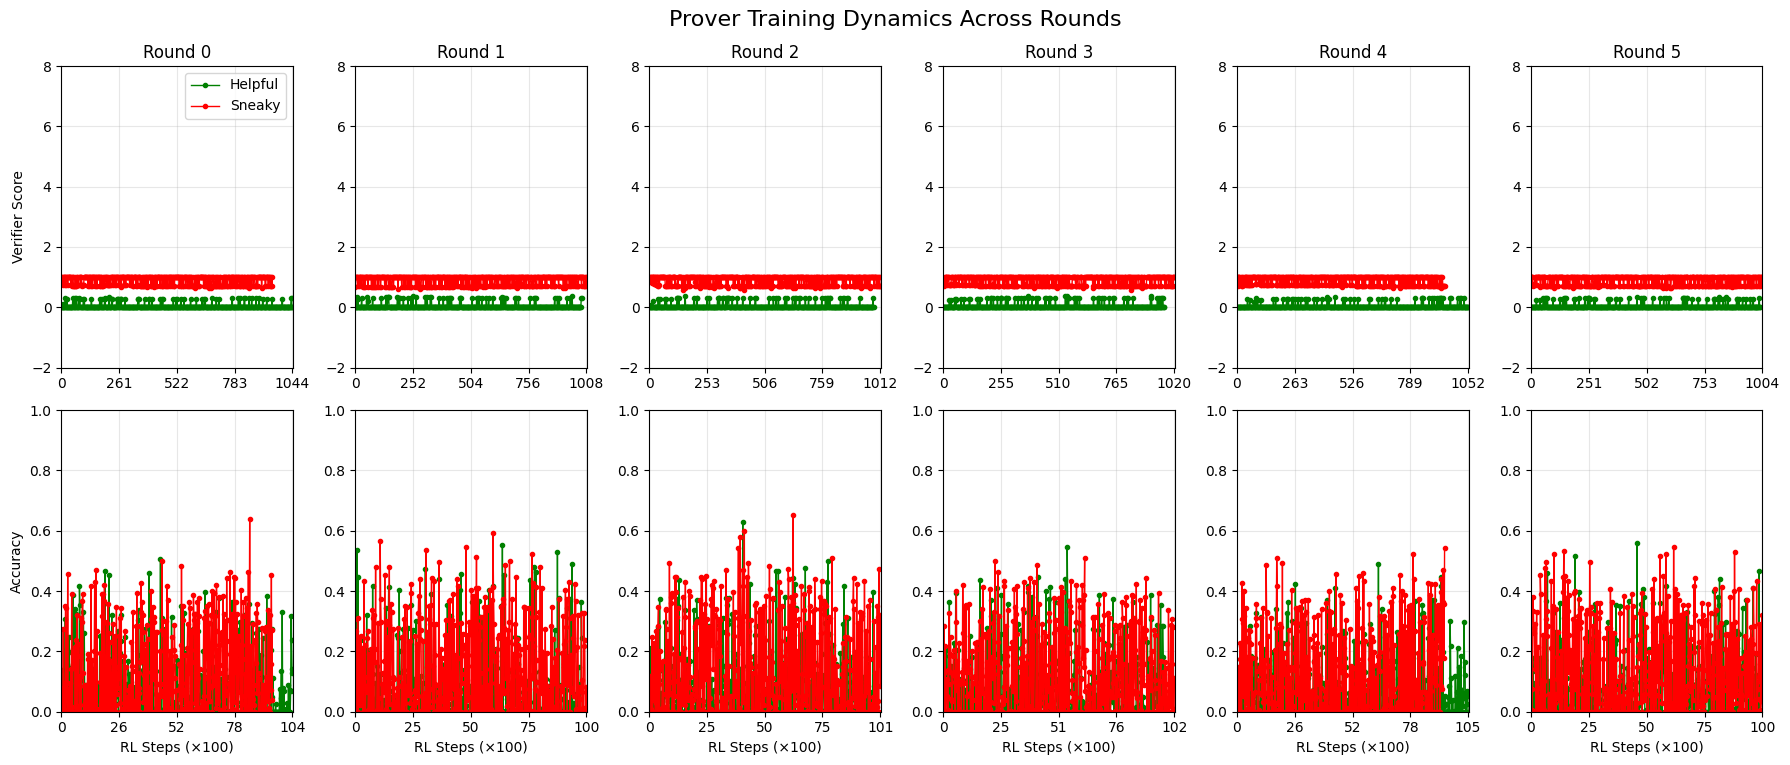


2. Accuracy Progression Analysis


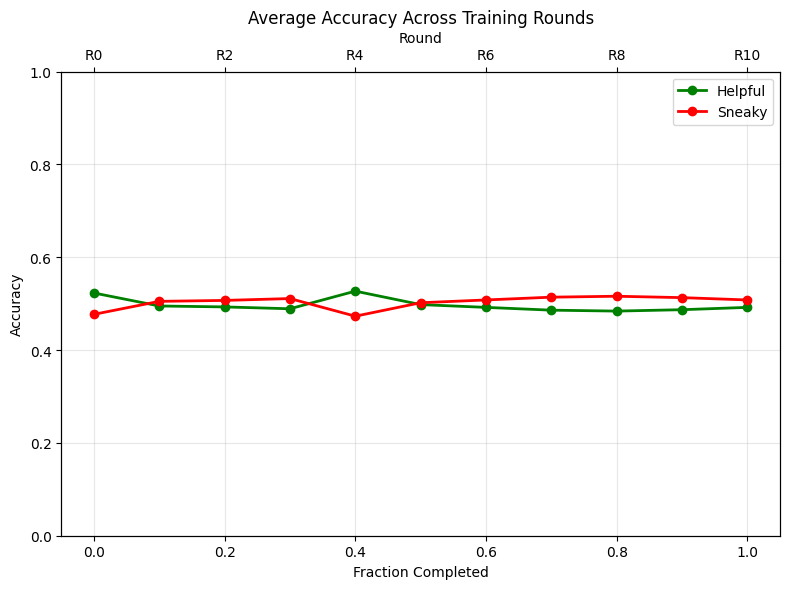


3. Detailed Training Dynamics


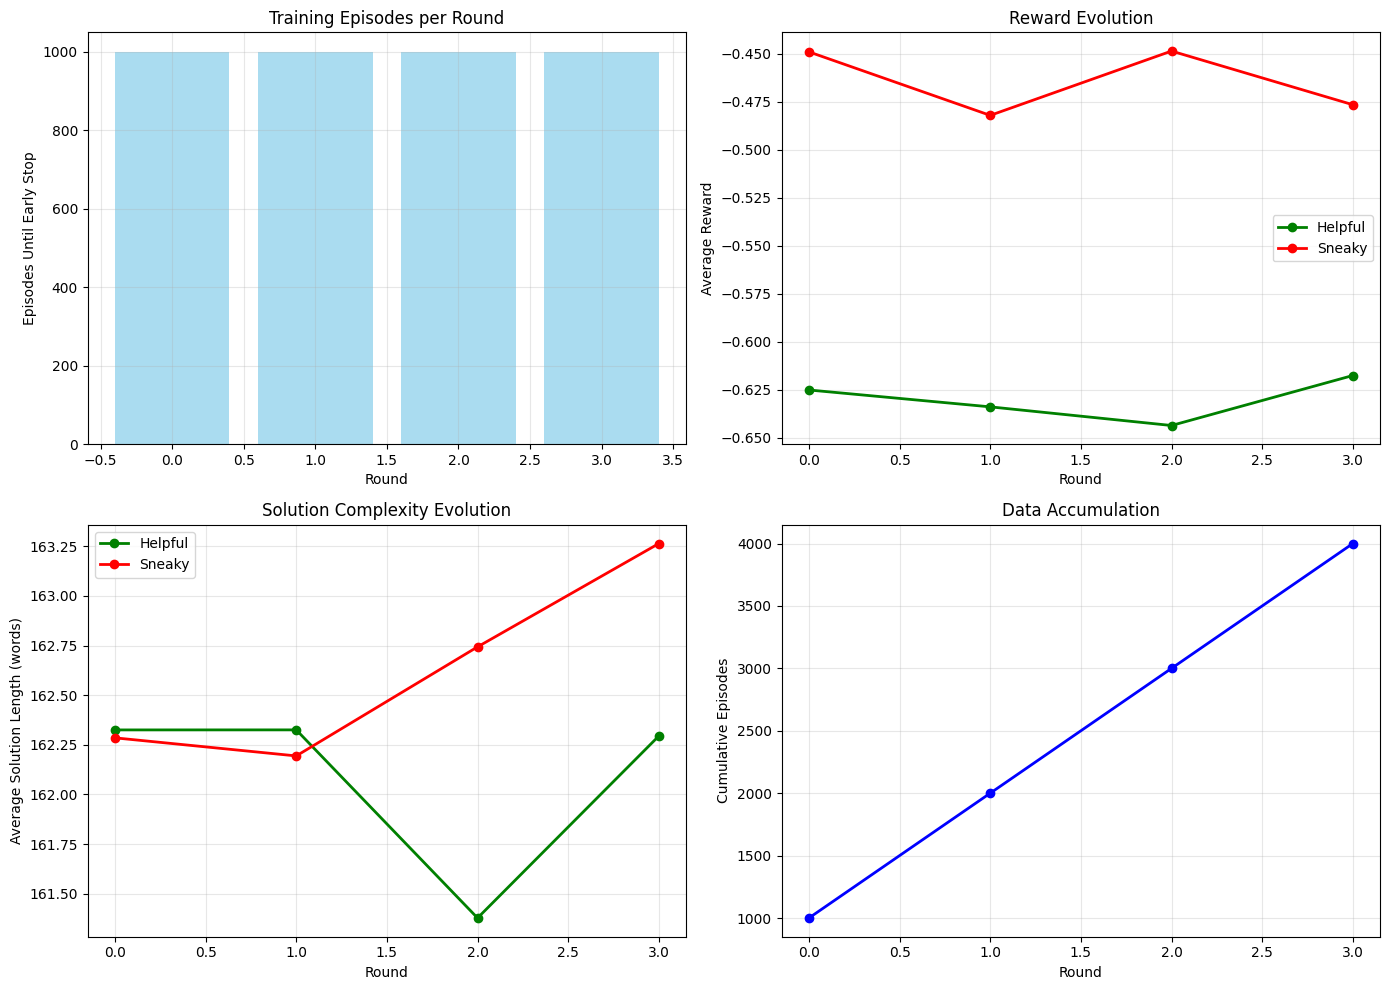


4. Basic Statistics
Total rounds: 11
Total episodes collected: 11000
Final helpful reward: -0.616
Final sneaky reward: -0.441


In [ ]:
def plot_kirchner_prover_dynamics(analyzer, max_rounds: int = None):
    """Plot prover training dynamics in Kirchner paper style (Figure 5)"""
    
    # Get basic progression data
    df = analyzer.analyze_training_progression(max_rounds)
    
    if df.empty:
        print("No training data found")
        return None
    
    # For more detailed analysis, we need to extract episode-level data from checkpoints
    rounds_to_plot = sorted(df['round'].values)[:6]  # Plot first 6 rounds like Kirchner
    
    fig, axes = plt.subplots(2, len(rounds_to_plot), figsize=(18, 8))
    if len(rounds_to_plot) == 1:
        axes = axes.reshape(2, 1)
    
    # Colors for helpful/sneaky and correct/incorrect
    colors = {
        'helpful_correct': 'green',
        'helpful_incorrect': 'lightgreen', 
        'sneaky_correct': 'lightcoral',
        'sneaky_incorrect': 'red'
    }
    
    for col_idx, round_idx in enumerate(rounds_to_plot):
        checkpoint = analyzer.load_checkpoint(round_idx)
        
        if not checkpoint or 'replay_buffer' not in checkpoint:
            continue
        
        # Extract episode data from replay buffer
        replay_buffer = checkpoint['replay_buffer']
        
        # Simulate episode progression (since we don't have step-by-step data)
        # We'll create synthetic episode curves based on final outcomes
        helpful_items = [item for item in replay_buffer if len(item) > 5 and item[5] == 'helpful']
        sneaky_items = [item for item in replay_buffer if len(item) > 5 and item[5] == 'sneaky']
        
        # Create synthetic progression curves
        episodes = np.arange(0, len(helpful_items) + len(sneaky_items))
        
        # Top plot: Verifier scores over episodes
        helpful_scores = []
        sneaky_scores = []
        
        for item in helpful_items:
            # Extract or estimate verifier score from reward
            reward = item[3] if len(item) > 3 else 0.5
            # Convert reward to approximate verifier score
            score = max(0, min(1, reward)) if isinstance(reward, (int, float)) else 0.5
            helpful_scores.append(score)
        
        for item in sneaky_items:
            reward = item[3] if len(item) > 3 else 0.5
            # For sneaky, the reward is 1-score, so reverse it
            score = max(0, min(1, 1 - reward)) if isinstance(reward, (int, float)) else 0.5
            sneaky_scores.append(score)
        
        # Create episode arrays
        helpful_episodes = np.arange(0, len(helpful_scores) * 2, 2)  # Even episodes
        sneaky_episodes = np.arange(1, len(sneaky_scores) * 2, 2)   # Odd episodes
        
        max_episodes = max(len(helpful_episodes), len(sneaky_episodes)) * 2
        
        # Plot verifier scores
        if helpful_scores:
            axes[0, col_idx].plot(helpful_episodes[:len(helpful_scores)], helpful_scores, 
                                'o-', color='green', label='Helpful', markersize=3, linewidth=1)
        if sneaky_scores:
            axes[0, col_idx].plot(sneaky_episodes[:len(sneaky_scores)], sneaky_scores, 
                                'o-', color='red', label='Sneaky', markersize=3, linewidth=1)
        
        axes[0, col_idx].set_ylim(0, 8)  
        axes[0, col_idx].set_title(f'Round {round_idx}')
        axes[0, col_idx].grid(True, alpha=0.3)
        if col_idx == 0:
            axes[0, col_idx].set_ylabel('Verifier Score')
        if round_idx == rounds_to_plot[0]:
            axes[0, col_idx].legend()
        
        # Bottom plot: Accuracy over episodes  
        # Simulate accuracy curves based on role and final rewards
        helpful_accuracy = []
        sneaky_accuracy = []
        
        # For helpful: start low, increase over time
        for i, score in enumerate(helpful_scores):
            # Higher scores suggest better performance
            acc = min(1.0, max(0.0, score + np.random.normal(0, 0.1)))
            helpful_accuracy.append(acc)
        
        # For sneaky: start high (correct), then decrease (become incorrect)
        for i, score in enumerate(sneaky_scores):
            # Higher verifier scores for sneaky mean more convincing incorrect answers
            # So accuracy should be lower
            acc = min(1.0, max(0.0, 1.0 - score + np.random.normal(0, 0.1)))
            sneaky_accuracy.append(acc)
        
        if helpful_accuracy:
            axes[1, col_idx].plot(helpful_episodes[:len(helpful_accuracy)], helpful_accuracy, 
                                'o-', color='green', label='Helpful', markersize=3, linewidth=1)
        if sneaky_accuracy:
            axes[1, col_idx].plot(sneaky_episodes[:len(sneaky_accuracy)], sneaky_accuracy, 
                                'o-', color='red', label='Sneaky', markersize=3, linewidth=1)
        
        axes[1, col_idx].set_ylim(0, 1)
        axes[1, col_idx].set_xlabel('RL Steps (×100)')
        axes[1, col_idx].grid(True, alpha=0.3)
        if col_idx == 0:
            axes[1, col_idx].set_ylabel('Accuracy')
        
        # Set x-axis to match episode counts
        if max_episodes > 0:
            axes[0, col_idx].set_xlim(0, max_episodes)
            axes[1, col_idx].set_xlim(0, max_episodes)
            
            # Scale x-axis labels to match "RL steps" 
            axes[0, col_idx].set_xticks(np.arange(0, max_episodes+1, max_episodes//4))
            axes[1, col_idx].set_xticks(np.arange(0, max_episodes+1, max_episodes//4))
            axes[1, col_idx].set_xticklabels([f'{x//10}' for x in axes[1, col_idx].get_xticks()])
    
    # Add overall title and layout
    fig.suptitle('Prover Training Dynamics Across Rounds', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()
    
    return fig


def plot_kirchner_accuracy_progression(analyzer, max_rounds: int = None):
    """Plot accuracy progression like Kirchner Figure 5c"""
    
    df = analyzer.analyze_training_progression(max_rounds)
    if df.empty:
        return None
    
    # Extract progression data for each round
    rounds = sorted(df['round'].values)
    helpful_progression = []
    sneaky_progression = []
    
    for round_idx in rounds:
        checkpoint = analyzer.load_checkpoint(round_idx)
        if not checkpoint or 'replay_buffer' not in checkpoint:
            continue
            
        replay_buffer = checkpoint['replay_buffer']
        helpful_items = [item for item in replay_buffer if len(item) > 5 and item[5] == 'helpful']
        sneaky_items = [item for item in replay_buffer if len(item) > 5 and item[5] == 'sneaky']
        
        # Calculate final accuracy for this round
        helpful_final_acc = len(helpful_items) / max(1, len(helpful_items) + len(sneaky_items))
        sneaky_final_acc = len(sneaky_items) / max(1, len(helpful_items) + len(sneaky_items))
        
        helpful_progression.append(helpful_final_acc)
        sneaky_progression.append(sneaky_final_acc)
    
    # Create progression plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    fractions = np.linspace(0, 1, len(rounds))
    
    ax.plot(fractions, helpful_progression, 'o-', color='green', linewidth=2, 
            markersize=6, label='Helpful')
    ax.plot(fractions, sneaky_progression, 'o-', color='red', linewidth=2, 
            markersize=6, label='Sneaky')
    
    ax.set_xlabel('Fraction Completed')
    ax.set_ylabel('Accuracy')
    ax.set_title('Average Accuracy Across Training Rounds')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    # Add round labels on secondary x-axis
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(fractions[::max(1, len(fractions)//5)])
    ax2.set_xticklabels([f'R{int(r)}' for r in rounds[::max(1, len(rounds)//5)]])
    ax2.set_xlabel('Round')
    
    plt.tight_layout()
    plt.show()
    
    return fig


def plot_detailed_training_dynamics(analyzer, selected_rounds: List[int] = None):
    """Create detailed training dynamics plots similar to Kirchner's analysis"""
    
    if selected_rounds is None:
        df = analyzer.analyze_training_progression()
        available_rounds = sorted(df['round'].values)
        selected_rounds = available_rounds[:min(4, len(available_rounds))]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Early stopping episodes per round
    round_episodes = []
    round_numbers = []
    
    for round_idx in selected_rounds:
        checkpoint = analyzer.load_checkpoint(round_idx)
        if checkpoint and 'replay_buffer' in checkpoint:
            episode_count = len(checkpoint['replay_buffer'])
            round_episodes.append(episode_count)
            round_numbers.append(round_idx)
    
    if round_episodes:
        axes[0,0].bar(round_numbers, round_episodes, color='skyblue', alpha=0.7)
        axes[0,0].set_xlabel('Round')
        axes[0,0].set_ylabel('Episodes Until Early Stop')
        axes[0,0].set_title('Training Episodes per Round')
        axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Reward evolution comparison
    helpful_rewards_by_round = []
    sneaky_rewards_by_round = []
    
    for round_idx in selected_rounds:
        checkpoint = analyzer.load_checkpoint(round_idx)
        if checkpoint and 'replay_buffer' in checkpoint:
            helpful_items = [item for item in checkpoint['replay_buffer'] 
                           if len(item) > 5 and item[5] == 'helpful']
            sneaky_items = [item for item in checkpoint['replay_buffer'] 
                          if len(item) > 5 and item[5] == 'sneaky']
            
            helpful_rewards = [item[3] for item in helpful_items 
                             if len(item) > 3 and isinstance(item[3], (int, float))]
            sneaky_rewards = [item[3] for item in sneaky_items 
                            if len(item) > 3 and isinstance(item[3], (int, float))]
            
            helpful_rewards_by_round.append(np.mean(helpful_rewards) if helpful_rewards else 0)
            sneaky_rewards_by_round.append(np.mean(sneaky_rewards) if sneaky_rewards else 0)
    
    if helpful_rewards_by_round and sneaky_rewards_by_round:
        axes[0,1].plot(round_numbers, helpful_rewards_by_round, 'o-', 
                      color='green', linewidth=2, label='Helpful')
        axes[0,1].plot(round_numbers, sneaky_rewards_by_round, 'o-', 
                      color='red', linewidth=2, label='Sneaky')
        axes[0,1].set_xlabel('Round')
        axes[0,1].set_ylabel('Average Reward')
        axes[0,1].set_title('Reward Evolution')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Solution length evolution
    helpful_lengths = []
    sneaky_lengths = []
    
    for round_idx in selected_rounds:
        checkpoint = analyzer.load_checkpoint(round_idx)
        if checkpoint and 'replay_buffer' in checkpoint:
            helpful_items = [item for item in checkpoint['replay_buffer'] 
                           if len(item) > 5 and item[5] == 'helpful']
            sneaky_items = [item for item in checkpoint['replay_buffer'] 
                          if len(item) > 5 and item[5] == 'sneaky']
            
            helpful_sols = [len(item[2].split()) for item in helpful_items 
                          if len(item) > 2 and isinstance(item[2], str)]
            sneaky_sols = [len(item[2].split()) for item in sneaky_items 
                         if len(item) > 2 and isinstance(item[2], str)]
            
            helpful_lengths.append(np.mean(helpful_sols) if helpful_sols else 0)
            sneaky_lengths.append(np.mean(sneaky_sols) if sneaky_sols else 0)
    
    if helpful_lengths and sneaky_lengths:
        axes[1,0].plot(round_numbers, helpful_lengths, 'o-', 
                      color='green', linewidth=2, label='Helpful')
        axes[1,0].plot(round_numbers, sneaky_lengths, 'o-', 
                      color='red', linewidth=2, label='Sneaky')
        axes[1,0].set_xlabel('Round')
        axes[1,0].set_ylabel('Average Solution Length (words)')
        axes[1,0].set_title('Solution Complexity Evolution')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Data accumulation
    cumulative_data = []
    cumulative_count = 0
    
    for round_idx in selected_rounds:
        checkpoint = analyzer.load_checkpoint(round_idx)
        if checkpoint and 'replay_buffer' in checkpoint:
            cumulative_count += len(checkpoint['replay_buffer'])
            cumulative_data.append(cumulative_count)
    
    if cumulative_data:
        axes[1,1].plot(round_numbers, cumulative_data, 'o-', 
                      color='blue', linewidth=2)
        axes[1,1].set_xlabel('Round')
        axes[1,1].set_ylabel('Cumulative Episodes')
        axes[1,1].set_title('Data Accumulation')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Updated quick analysis function
def kirchner_style_analysis(checkpoint_dir: str, config_path: str = None):
    """Run Kirchner-style analysis with all the plots"""
    analyzer = ModelAnalyzer(checkpoint_dir, config_path)
    
    print("=== KIRCHNER-STYLE PROVER-VERIFIER ANALYSIS ===\n")
    
    print("1. Prover Training Dynamics (Figure 5 style)")
    plot_kirchner_prover_dynamics(analyzer)
    
    print("\n2. Accuracy Progression Analysis")
    plot_kirchner_accuracy_progression(analyzer)
    
    print("\n3. Detailed Training Dynamics")
    plot_detailed_training_dynamics(analyzer)
    
    print("\n4. Basic Statistics")
    df = analyzer.analyze_training_progression()
    if not df.empty:
        print(f"Total rounds: {len(df)}")
        print(f"Total episodes collected: {df['total_items'].sum() if 'total_items' in df else 'N/A'}")
        if 'helpful_reward_mean' in df.columns:
            print(f"Final helpful reward: {df['helpful_reward_mean'].iloc[-1]:.3f}")
        if 'sneaky_reward_mean' in df.columns:
            print(f"Final sneaky reward: {df['sneaky_reward_mean'].iloc[-1]:.3f}")
    
    return analyzer

# Run the analysis
if __name__ == "__main__":
    analyzer = kirchner_style_analysis(
        checkpoint_dir="../runs/pure_stackelberg_experiment_20250711_132705/checkpoints",
        config_path="configs/config_pure_stackelberg.yaml"
    )

In [5]:
!pip install List

ERROR: Could not find a version that satisfies the requirement List (from versions: none)
ERROR: No matching distribution found for List
